## I.  Import data and briefly examine it

In [123]:
#import various modules I will use in the analysis
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
from sklearn import linear_model,svm,ensemble,cross_validation,grid_search,metrics,kernel_ridge
import matplotlib.dates as dates
%matplotlib inline

In [124]:
df=pd.read_csv('C:/Users/Yu Yu/Documents/career/finance/test/cubist_project/data.csv')
df.head()

,date,signal,spy_close_price
0,20120103,3.107767,127.495
1,20120104,3.107282,127.700
2,20120105,3.099757,128.040
3,20120106,3.134223,127.710
4,20120109,3.135922,128.020


Change the date field into datetime format and make it index

In [125]:
df.date=pd.to_datetime(df.date,unit='D',format='%Y%m%d')
df=df.set_index('date')

## II. Remove data errors and replace them with data in the last normal day prior
I could have used average values between before and after the error date, or add some random disturbance to the average. But given we have a long time series and only a few error data points, using the value from the day before won't make a huge difference. 

It seems the Signal does contain useful information about S&P returns, however the leading periods changes from time to time. 

<function matplotlib.pyplot.show>

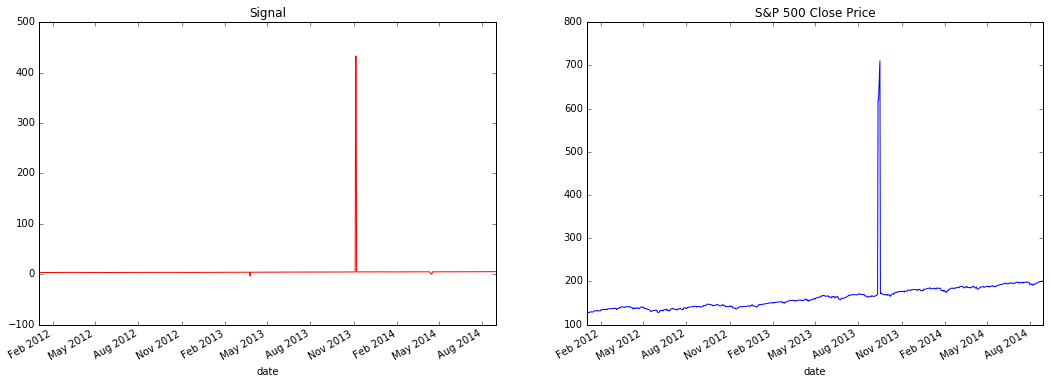

In [126]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1=df['signal'].plot(c='r')
plt.title('Signal')
plt.show
ax2 = fig.add_subplot(122,sharex=ax1)
ax2=df['spy_close_price'].plot()
plt.title('S&P 500 Close Price')
plt.show

From the plot above, it seems that both series have unreasonably large data points. Replace data errors with the previous normal period values

In [127]:
df[df['signal']>100]['signal']

date
2013-11-05    429.514563
2013-11-06    432.961165
Name: signal, dtype: float64

In [128]:
temp=df[df['signal']>100]['signal'].index
df.ix[temp,'signal']=df.ix['2013-11-04','signal']

In [129]:
df[df['spy_close_price']>250]['spy_close_price']

date
2013-09-12    618.95
2013-09-13    619.33
2013-09-16    710.31
Name: spy_close_price, dtype: float64

In [130]:
df['2013-09-11':'2013-09-16']

,signal,spy_close_price
date,,
2013-09-11,4.200267,169.40
2013-09-12,4.193204,618.95
2013-09-13,4.143689,619.33
2013-09-16,4.124515,710.31


In [131]:
temp=df[df['spy_close_price']>250]['spy_close_price'].index
df.ix[temp,'spy_close_price']=df.ix['2013-09-11','spy_close_price']

<function matplotlib.pyplot.show>

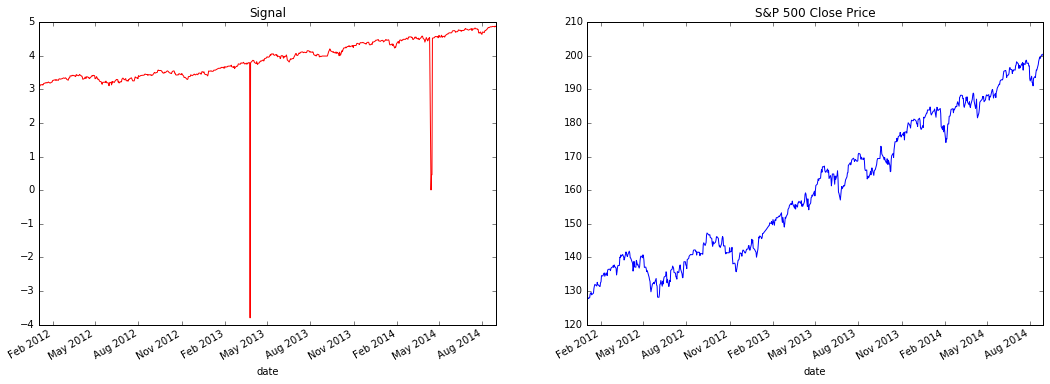

In [132]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1=df['signal'].plot(c='r')
plt.title('Signal')
plt.show
ax2 = fig.add_subplot(122,sharex=ax1)
ax2=df['spy_close_price'].plot()
plt.title('S&P 500 Close Price')
plt.show

Checked again, S&P 500 looks fine. Signal seems to still have some particularly low numbers that are not right. Replace them with previous periods normal numbers. 

In [133]:
df[df['signal']<2.5]['signal']

date
2013-03-26   -3.802670
2014-04-14    0.004560
2014-04-15    0.454976
2014-04-16    0.455898
Name: signal, dtype: float64

In [134]:
df.ix['2013-03-26','signal']=df.ix['2013-03-25','signal']

In [135]:
temp=df[df['signal']<2.5]['signal'].index
df.ix[temp,'signal']=df.ix['2014-04-11','signal']

<function matplotlib.pyplot.show>

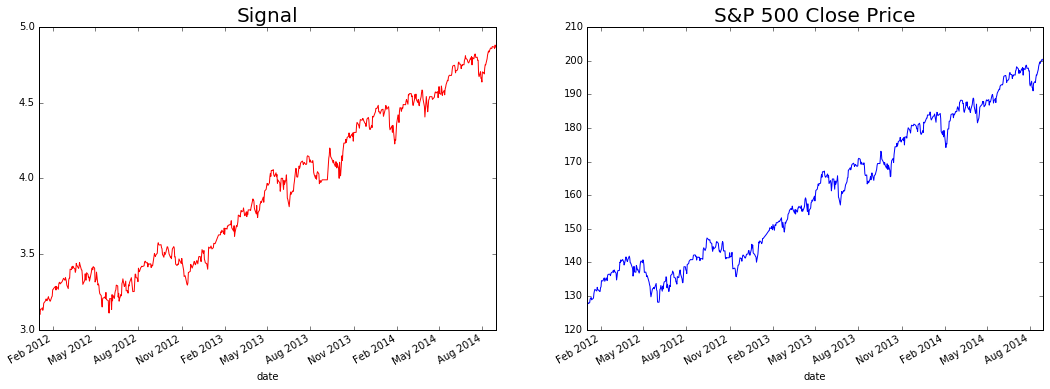

In [136]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1=df['signal'].plot(c='r')
plt.title('Signal',fontsize=20)
ax2 = fig.add_subplot(122,sharex=ax1)
ax2=df['spy_close_price'].plot()
plt.title('S&P 500 Close Price',fontsize=20)
plt.show

Now both signal and spy looks normal without obvious data errors. The plots of the two time series seem in syn. 
### Calculate the correlations between the signal and S&P 500 series

In [137]:
df.corr()

,signal,spy_close_price
signal,1.000000,0.995074
spy_close_price,0.995074,1.000000


Because signal is received at the same time as spy_close_price, I can't use the same day information of signal to predict SPY. Rather, I shift signal down one day, which means in day 2, we can use the signal received on day 1 and before for SPY prediction. 
### Shift signal by one day

In [138]:
df2=df['signal'].shift(1)
df2=df2.to_frame('signal_shift')
df3=pd.merge(df,df2,left_index=True,right_index=True,how='left')
df3[df3['signal_shift'].isnull()]
df3.drop(df3.index[[0]])

,signal,spy_close_price,signal_shift
date,,,
2012-01-04,3.107282,127.700,3.107767
2012-01-05,3.099757,128.040,3.107282
2012-01-06,3.134223,127.710,3.099757
2012-01-09,3.135922,128.020,3.134223
2012-01-10,3.143447,129.130,3.135922
2012-01-11,3.127184,129.200,3.143447
2012-01-12,3.139320,129.510,3.127184
2012-01-13,3.174029,128.840,3.139320
2012-01-17,3.190777,129.340,3.174029


In [139]:
df3.corr()

,signal,spy_close_price,signal_shift
signal,1.000000,0.995074,0.998276
spy_close_price,0.995074,1.000000,0.996097
signal_shift,0.998276,0.996097,1.000000


After shifting, signal_shift still looks highly correlated with spy_close_price

<function matplotlib.pyplot.show>

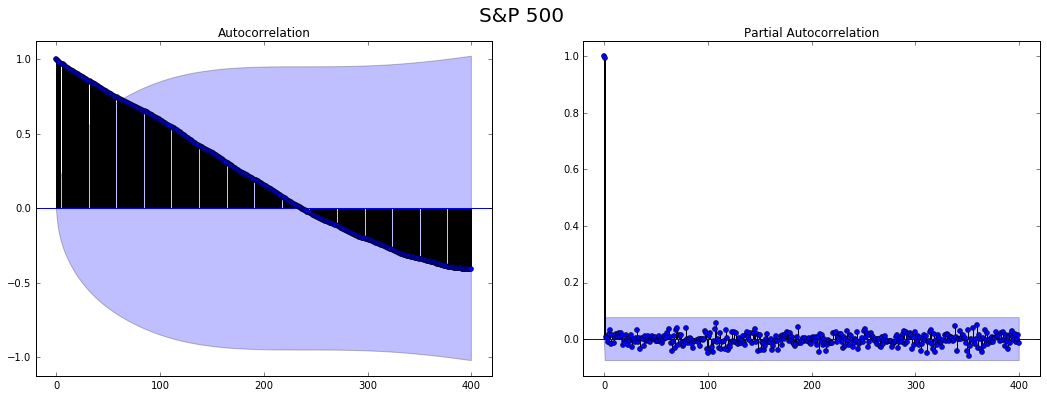

In [140]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(df3['spy_close_price'],lags=400,ax=ax1)
ax1.set_title('Autocorrelation',fontsize=12)
plt.show
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(df3['spy_close_price'],lags=400,ax=ax2)
ax2.set_title('Partial Autocorrelation',fontsize=12)
fig.suptitle('S&P 500',fontsize=20)
plt.show


Looks like S&P 500 are strongly autocorrelated. In that case predicting the absolute value of S&P 500 is not very useful. I will calculate the daily returns and check again.

## III. Calculate the S&P 500 and Signal daily returns

In [141]:
df3['spy_returns']=df3['spy_close_price']-df3['spy_close_price'].shift(1)

In [142]:
df3['signal_shift_returns']=df3['signal_shift']-df3['signal_shift'].shift(1)

check the s&p 500 returns. In order to do plotting conviniently, I drop the first several periods when there are no returns. 

In [143]:
df3=df3.drop(df3.index[[0,1]])

<function matplotlib.pyplot.show>

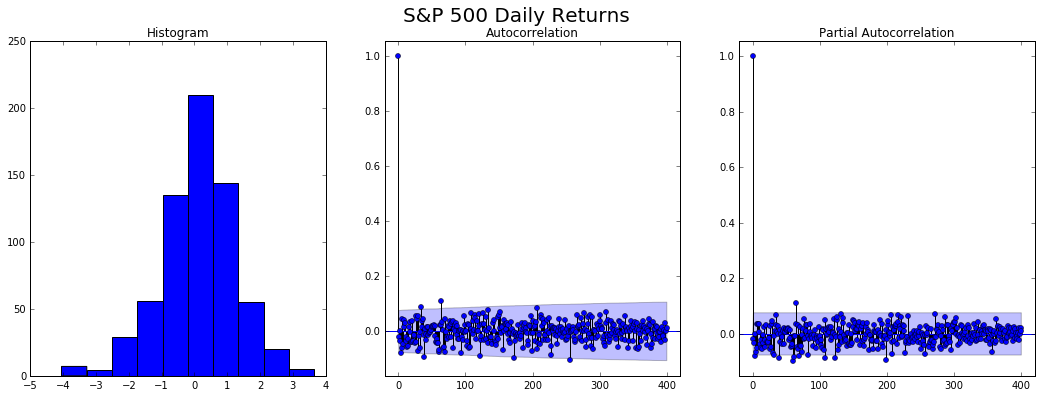

In [144]:
fig = plt.figure(figsize=(18,6))
fig.suptitle('S&P 500 Daily Returns',fontsize=20)
ax1 = fig.add_subplot(131)
ax1=plt.hist(df3['spy_returns'])
plt.title('Histogram')
plt.show
ax2 = fig.add_subplot(132)
fg=sm.graphics.tsa.plot_acf(df3['spy_returns'],lags=400,ax=ax2)
ax2.set_title('Autocorrelation')
plt.show
ax3 = fig.add_subplot(133)
fg=sm.graphics.tsa.plot_pacf(df3['spy_returns'],lags=400,ax=ax3)
ax3.set_title('Partial Autocorrelation')
plt.show

It seems that the S&P 500 Daily Returns are mostly not autocorrelated and can be used as target variable for prediction. 

<function matplotlib.pyplot.show>

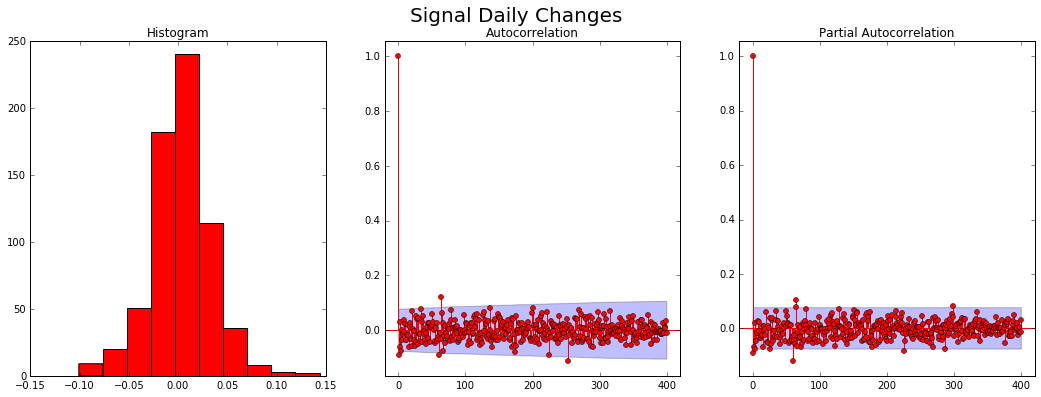

In [145]:
fig = plt.figure(figsize=(18,6))
fig.suptitle('Signal Daily Changes',fontsize=20)
ax1 = fig.add_subplot(131)
ax1=plt.hist(df3['signal_shift_returns'],color='red')
plt.title('Histogram')
ax2 = fig.add_subplot(132)
fg=sm.graphics.tsa.plot_acf(df3['signal_shift_returns'],lags=400,ax=ax2,color='red')
ax2.set_title('Autocorrelation')
ax3 = fig.add_subplot(133)
fg=sm.graphics.tsa.plot_pacf(df3['signal_shift_returns'],lags=400,ax=ax3,color='red')
ax3.set_title('Partial Autocorrelation')
plt.show

Try calculating correlations and plot out the daily returns. Can't tell obvious patterns.

In [146]:
df3[['spy_returns','signal_shift_returns']].corr()

,spy_returns,signal_shift_returns
spy_returns,1.000000,-0.071886
signal_shift_returns,-0.071886,1.000000


<function matplotlib.pyplot.show>

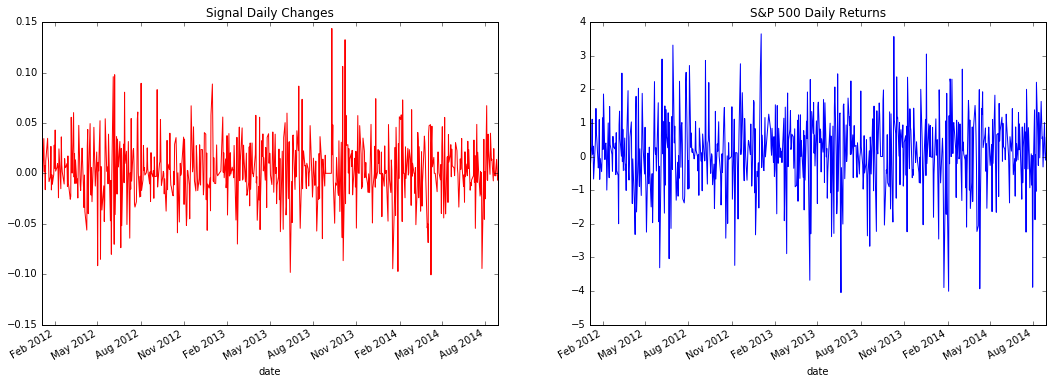

In [147]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(122)
ax1=df3['spy_returns'].plot()
plt.title('S&P 500 Daily Returns')
plt.show
ax2 = fig.add_subplot(121,sharex=ax1)
ax2=df3['signal_shift_returns'].plot(c='r')
plt.title('Signal Daily Changes')
plt.show

No obvious pattern appear from the direct plotting of return series. Next I examine the summary statistics and rolling means and std. 

In [148]:
df3['signal_shift_returns'].describe()

count    665.000000
mean       0.002667
std        0.030767
min       -0.100726
25%       -0.012621
50%        0.000243
75%        0.021238
max        0.143689
Name: signal_shift_returns, dtype: float64

In [149]:
df3['spy_returns'].describe()

count    665.000000
mean       0.109789
std        1.149679
min       -4.050000
25%       -0.511000
50%        0.110000
75%        0.875000
max        3.650000
Name: spy_returns, dtype: float64

## IV. Calculate moving averages and std for S&P 500 and signal

Moving averages remove the noices in daily returns so that I can see the longer term trends more clearly.

In [150]:
spy_mean=pd.rolling_mean(df3['spy_returns'],60,min_periods=10)
signal_mean=pd.rolling_mean(df3['signal_shift_returns'],60,min_periods=10)

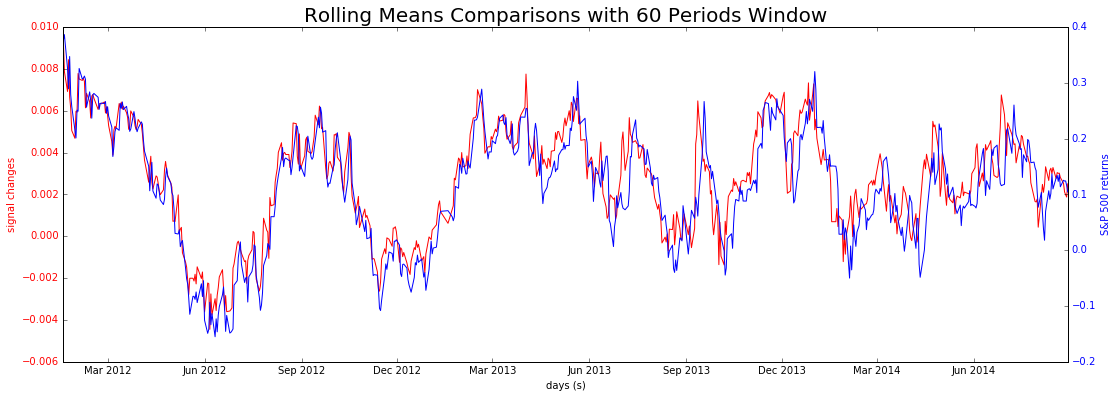

In [151]:
fig, ax1 = plt.subplots(figsize=(18,6))
ax1.plot(signal_mean, 'r-')
ax1.set_xlabel('days (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('signal changes', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(spy_mean, 'b-')
ax2.set_ylabel('S&P 500 returns', color='b')
ax2.set_title('Rolling Means Comparisons with 60 Periods Window',fontsize=20)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
plt.show()

It seems that the signal rolling means are preceding the S&P 500

### Calculate exponentially weighted moving average

In [152]:
spy_ewma=pd.ewma(df3['spy_returns'],span=60)
signal_ewma=pd.ewma(df3['signal_shift_returns'],span=60)

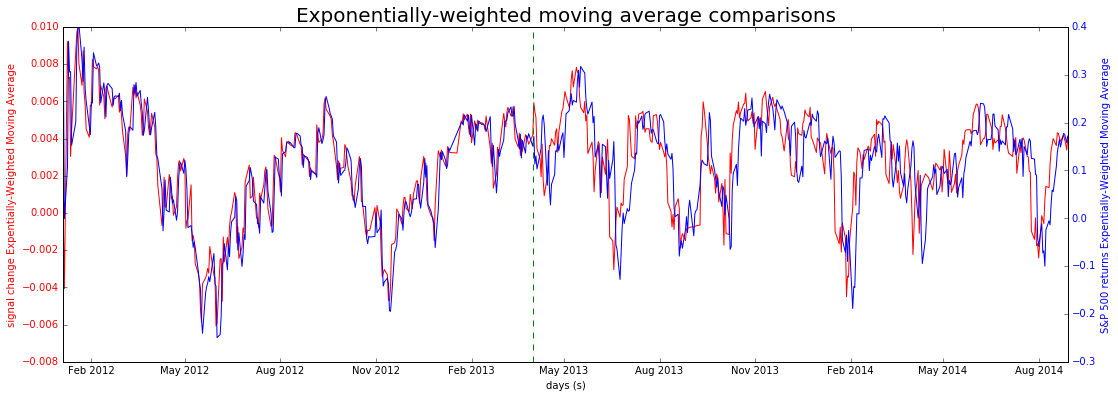

In [153]:
fig, ax1 = plt.subplots(figsize=(18,6))
ax1.plot(signal_ewma, 'r-')
ax1.set_xlabel('days (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('signal change Expentially-Weighted Moving Average', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(spy_ewma, 'b-')
ax2.set_ylabel('S&P 500 returns Expentially-Weighted Moving Average', color='b')
ax2.set_title('Exponentially-weighted moving average comparisons',fontsize=20)
ax2.axis(ymin=-0.3,ymax=0.4)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
plt.axvline(x='2013-04-01',c='g',linestyle='dashed')
plt.show()

The two types of moving averages tell similar stories. I notice that somewhere around April 2013, the lag periods between signal and S&P 500 returns have changed. 

### Find out when the switch happened exactly

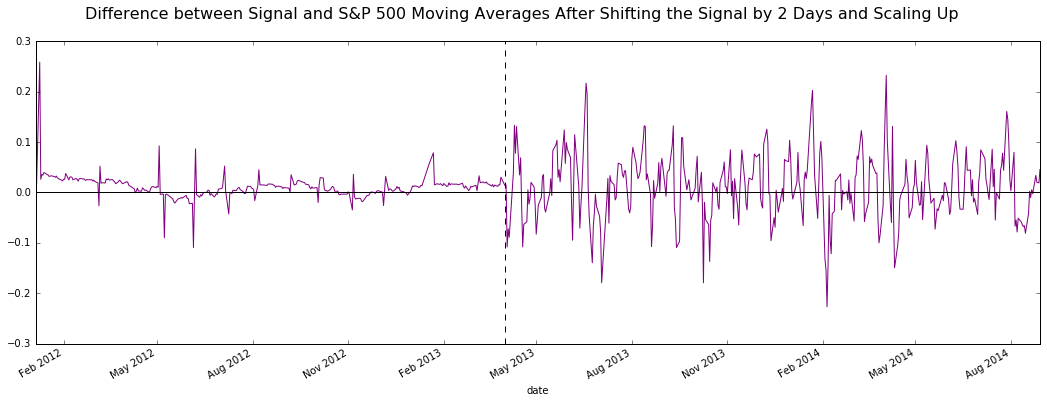

In [154]:
diff=spy_ewma-signal_ewma.shift(1)*df3['spy_returns'].std()/df3['signal_shift_returns'].std()
diff.plot(figsize=(18,6),color='purple')
plt.axvline(x='2013-04-01',c='black',linestyle='dashed')
plt.axhline(y=0,c='black')
plt.suptitle('Difference between Signal and S&P 500 Moving Averages After Shifting the Signal by 2 Days and Scaling Up',fontsize=16)

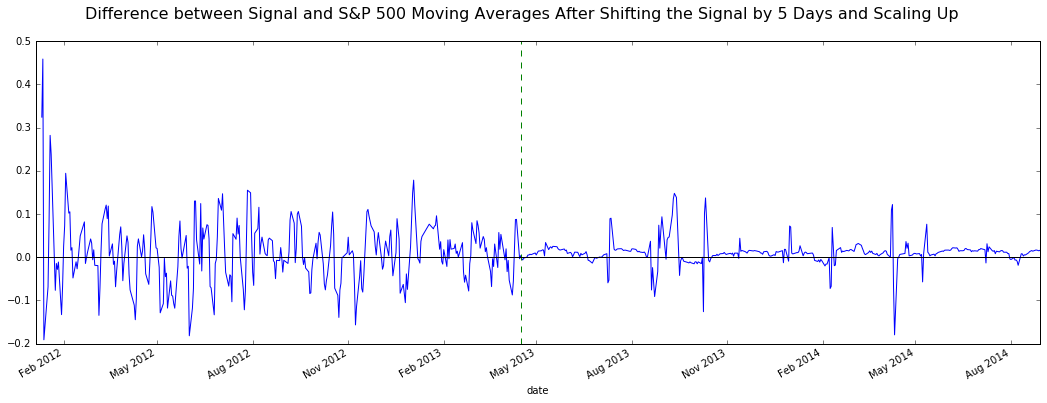

In [155]:
diff=spy_ewma-signal_ewma.shift(4)*df3['spy_returns'].std()/df3['signal_shift_returns'].std()
diff.plot(figsize=(18,6))
plt.axvline(x='2013-04-16',c='g',linestyle='dashed')
plt.axhline(y=0,c='black')
plt.suptitle('Difference between Signal and S&P 500 Moving Averages After Shifting the Signal by 5 Days and Scaling Up',fontsize=16)

### Before the end of March 2013, 2 days lag of signal works well. After April 1 2013, the lags seem to change to 5 days.  

In [156]:
compare=pd.DataFrame(dict(spy_ewma = spy_ewma, signal_ewma_2d_shift = signal_ewma.shift(1)*df3['spy_returns'].std()/df3['signal_shift_returns'].std()))
compare['2012-01-04':'2013-03-31'].corr()

,signal_ewma_2d_shift,spy_ewma
signal_ewma_2d_shift,1.000000,0.985822
spy_ewma,0.985822,1.000000


In [157]:
compare=pd.DataFrame(dict(spy_ewma = spy_ewma, signal_ewma_5d_shift = signal_ewma.shift(4)*df3['spy_returns'].std()/df3['signal_shift_returns'].std()))
compare['2013-04-16':'2014-08-29'].corr()

,signal_ewma_5d_shift,spy_ewma
signal_ewma_5d_shift,1.000000,0.942251
spy_ewma,0.942251,1.000000


The correlation calculation above confirms this hypothesis. 

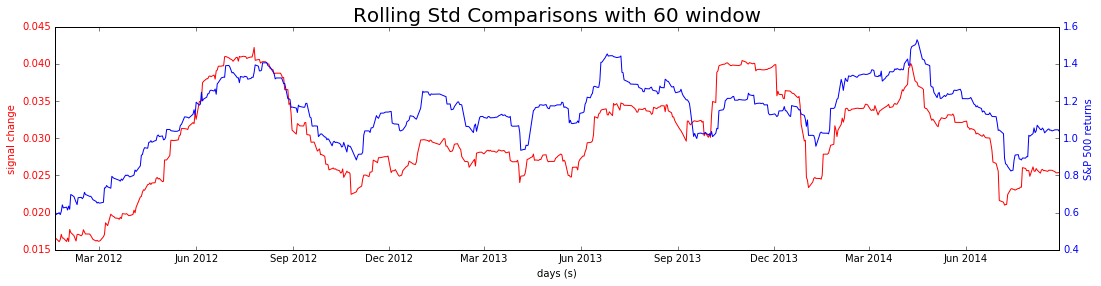

In [158]:
spy_std=pd.rolling_std(df3['spy_returns'],60,min_periods=10)
signal_std=pd.rolling_std(df3['signal_shift_returns'],60,min_periods=10)
fig, ax1 = plt.subplots(figsize=(18,4))
ax1.plot(df3.index, signal_std, 'r-')
ax1.set_xlabel('days (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('signal change', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(df3.index, spy_std, 'b-')
ax2.set_ylabel('S&P 500 returns', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
ax2.set_title('Rolling Std Comparisons with 60 window',fontsize=20)
plt.show()

From the examination of the rolling std, it seems that the market volatility increased significantly from the beginning from 2012 and stayed high. Both signal and S&P 500 volatility follows similar patterns. 

## V. Model Building
** I fit linear, kernel ridge, SVM, GBM onto S&P 500 Daily Returns using up to 7 lags of signal daily change **

5.1. I simplified the feature selection by using 7 lags because the time series investigation suggests that 7 lags of signal are sufficient to predict the patterns. 
5.2. I fit the model separately for first and second half of the sample because the signal lags are clearly different. In practice, we can't know when the signal lag will change, so the modeler will test the effectiveness of the prediction. if the model prediction deteriorates for a week or more, the modeler should refit the model with the most recent week or so data to see whether the pattern has changed. 

In [159]:
df_lag=np.zeros((len(df3),7))
for i in range(0,7):
    df_lag[:,i]=df3['signal_shift_returns'].shift(i)
df_lag2=pd.DataFrame(df_lag)
df_lag2.columns=['sr_lg1','sr_lg2','sr_lg3','sr_lg4','sr_lg5','sr_lg6','sr_lg7']
df_lag2=df_lag2.set_index(df3.index)
df_with_lags=pd.merge(df3,df_lag2,left_index=True,right_index=True,how='left')


In [160]:
a=df_with_lags.loc['2012-01-11':'2013-03-31']
b=df_with_lags.loc['2013-04-01':'2014-08-29']
array_a=a[['spy_returns','sr_lg1','sr_lg2','sr_lg3','sr_lg4','sr_lg5','sr_lg6','sr_lg7']].corr()[[0]]
array_b=b[['spy_returns','sr_lg1','sr_lg2','sr_lg3','sr_lg4','sr_lg5','sr_lg6','sr_lg7']].corr()[[0]]

<function matplotlib.pyplot.show>

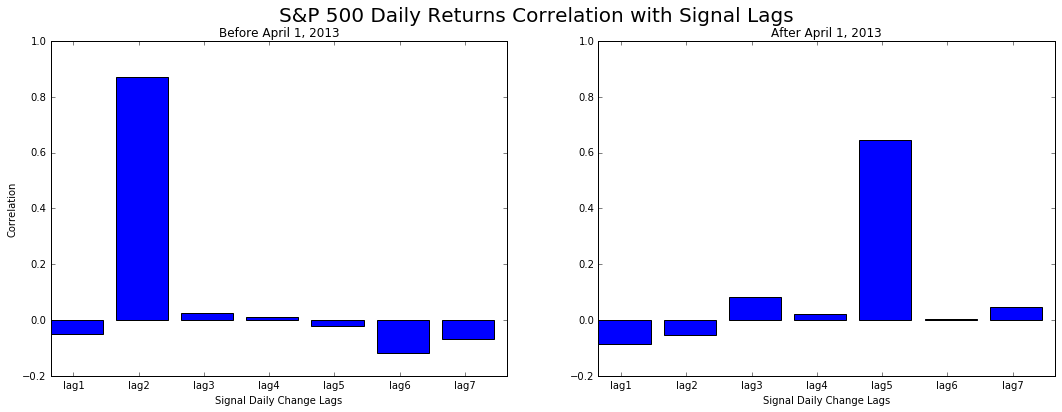

In [161]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(121)
ax1=plt.bar(np.arange(7),array_a['spy_returns'][1:8])
ax1=plt.title('Before April 1, 2013')
ax1=plt.xticks(np.arange(7)+0.35,('lag1','lag2','lag3','lag4','lag5','lag6','lag7'))
ax1=plt.yticks(np.arange(-0.2,1.2,0.2))
ax1=plt.ylabel('Correlation')
ax1=plt.xlabel('Signal Daily Change Lags')

ax2 = fig.add_subplot(122)
ax2=plt.bar(np.arange(7),array_b['spy_returns'][1:8])
ax2=plt.title('After April 1, 2013')
ax2=plt.xticks(np.arange(7)+0.35,('lag1','lag2','lag3','lag4','lag5','lag6','lag7'))
ax2=plt.yticks(np.arange(-0.2,1.2,0.2))
ax2=plt.xlabel('Signal Daily Change Lags')

fig.suptitle('S&P 500 Daily Returns Correlation with Signal Lags',fontsize=20)
plt.show

The pattern we found in moving averages are confirmed here, although the correlation in the post April 1, 2013 period seems to have reduced. 

** Next Create Model Training and Validation Sample as well as Testing Sample **

In [162]:
#First half
X_1=df_lag2.loc['2012-01-13':'2013-03-31'].as_matrix()
y_1=df3.loc['2012-01-13':'2013-03-31','spy_returns'].as_matrix()
#Second half
X_2=df_lag2.loc['2013-04-01':'2014-08-29'].as_matrix()
y_2=df3.loc['2013-04-01':'2014-08-29','spy_returns'].as_matrix()
#Testing sets
X_1_test=X_1[-45:,:] #keep the last 30 days as testing
y_1_test=y_1[-45:]
X_2_test=X_2[-60:,:] #keep the last 30 days as testing
y_2_test=y_2[-60:]
#Training sets
X_1_training=X_1[:-45,:] #keep the last 30 days as testing
y_1_training=y_1[:-45]
X_2_training=X_2[:-60:,:] #keep the last 30 days as testing
y_2_training=y_2[:-60]

** Create a dataframe to record the performance of different models **

In [163]:
columns=['Model','R^2','Residual sum of squares','Best Parameters','Data_Range']
model_comparison=pd.DataFrame(columns=columns)

In [164]:
def linear_version(X_tr,y_tr,X_te,y_te):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_tr, y_tr)
    rss=np.mean((regr.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    print('R^2: %.2f' % regr.score(X_te,  y_te))
    return (regr.score(X_te,  y_te),rss,regr.coef_)

In [165]:
#first half
R_2,Rss,Param=linear_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'linear', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

Residual sum of squares: 0.10
R^2: 0.89


In [166]:
#second half
R_2,Rss,Param=linear_version(X_2_training,y_2_training,X_2_test,y_2_test)
model_comparison = model_comparison.append({'Model':'linear', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':2},ignore_index=True)

Residual sum of squares: 0.26
R^2: 0.76


** Create cross validation class for time series data **

I can not use the sklearn cross validation class because we can not learn from later periods and validate on earlier periods. The training samples always have to precede the validation sample. When I create multiple fold cross validation, I first divide up the sample into n sections, assign the first section to training, the second section to validation, then assign the first two sections to training and the third section to validation and so on. 

In [167]:
class TimeSeriesCV():
    def __init__(self,n,fold):
        self.n=n
        self.fold=fold
    def __iter__(self):
        if self.n<(self.fold+1):
            print("too many folds")
        m=self.n%(self.fold+1)
        chunk=np.arange(self.n)#entire series
        size=(self.n-m)/(self.fold+1)#size of each fold, size of the first fold is size+m
        for i in np.arange(self.fold):
            train_index = chunk[0:(size*(i+1)+m)]
            test_index = chunk[(size*(i+1)+m):(size*(i+2)+m)]
            yield train_index, test_index
    def __len__(self):
        return self.fold 

** I conduct grid search for hyper-parameters of the subsequent model on cross validated development set, then calculate the model score on test (evaluation) set. **

In [168]:
def kernel_ridge_version(X_tr,y_tr,X_te,y_te):
    # Create linear regression object

    tuned_parameters = [{'kernel':['linear'],'alpha': [0.001,0.05,0.01,0.1,1]},
                         {'kernel':['rbf'],'alpha':[0.001,0.05,0.01,0.1,1],'gamma':[0.1,1,10,100,500]}]
    print("# Tuning hyper-parameters")
    clf = grid_search.GridSearchCV(kernel_ridge.KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=5))
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

In [169]:
#first half
R_2,Rss,Param=kernel_ridge_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'Kernel Ridge', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

# Tuning hyper-parameters
Best parameters set found on development set:
{'alpha': 0.1, 'gamma': 10, 'kernel': 'rbf'}
Grid scores on development set:
0.701 (+/-0.303) for {'alpha': 0.001, 'kernel': 'linear'}
0.602 (+/-0.333) for {'alpha': 0.05, 'kernel': 'linear'}
0.716 (+/-0.236) for {'alpha': 0.01, 'kernel': 'linear'}
0.496 (+/-0.362) for {'alpha': 0.1, 'kernel': 'linear'}
0.093 (+/-0.109) for {'alpha': 1, 'kernel': 'linear'}
0.715 (+/-0.253) for {'alpha': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.692 (+/-0.341) for {'alpha': 0.001, 'gamma': 1, 'kernel': 'rbf'}
0.522 (+/-0.710) for {'alpha': 0.001, 'gamma': 10, 'kernel': 'rbf'}
0.628 (+/-0.168) for {'alpha': 0.001, 'gamma': 100, 'kernel': 'rbf'}
0.396 (+/-0.239) for {'alpha': 0.001, 'gamma': 500, 'kernel': 'rbf'}
0.288 (+/-0.393) for {'alpha': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}
0.655 (+/-0.330) for {'alpha': 0.05, 'gamma': 1, 'kernel': 'rbf'}
0.726 (+/-0.261) for {'alpha': 0.05, 'gamma': 10, 'kernel': 'rbf'}
0.690 (+/-0.196) for {'alp

In [170]:
#second half
R_2,Rss,Param=kernel_ridge_version(X_2_training,y_2_training,X_2_test,y_2_test)
model_comparison = model_comparison.append({'Model':'Kernel Ridge', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':2},ignore_index=True)

# Tuning hyper-parameters
Best parameters set found on development set:
{'alpha': 1, 'gamma': 100, 'kernel': 'rbf'}
Grid scores on development set:
0.195 (+/-0.959) for {'alpha': 0.001, 'kernel': 'linear'}
0.271 (+/-0.540) for {'alpha': 0.05, 'kernel': 'linear'}
0.232 (+/-0.840) for {'alpha': 0.01, 'kernel': 'linear'}
0.257 (+/-0.388) for {'alpha': 0.1, 'kernel': 'linear'}
0.076 (+/-0.103) for {'alpha': 1, 'kernel': 'linear'}
0.218 (+/-0.902) for {'alpha': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.225 (+/-0.971) for {'alpha': 0.001, 'gamma': 1, 'kernel': 'rbf'}
-0.121 (+/-1.749) for {'alpha': 0.001, 'gamma': 10, 'kernel': 'rbf'}
-0.638 (+/-0.952) for {'alpha': 0.001, 'gamma': 100, 'kernel': 'rbf'}
0.100 (+/-0.098) for {'alpha': 0.001, 'gamma': 500, 'kernel': 'rbf'}
0.197 (+/-0.233) for {'alpha': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}
0.271 (+/-0.675) for {'alpha': 0.05, 'gamma': 1, 'kernel': 'rbf'}
0.308 (+/-0.753) for {'alpha': 0.05, 'gamma': 10, 'kernel': 'rbf'}
0.203 (+/-0.350) for {'al

In [171]:
def svm_version(X_tr,y_tr,X_te,y_te):
    # Create linear SVR object
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10,20,30, 50,60,70,80,90,100,1000]}]
    print("# Tuning hyper-parameters")

    clf = grid_search.GridSearchCV(svm.SVR(C=1), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=5),n_jobs=-1)
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

In [172]:
#first half
R_2,Rss,Param=svm_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'SVM', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

# Tuning hyper-parameters
Best parameters set found on development set:
{'kernel': 'linear', 'C': 50}
Grid scores on development set:
-0.078 (+/-0.105) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
-0.079 (+/-0.105) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
-0.076 (+/-0.106) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
-0.078 (+/-0.105) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
-0.054 (+/-0.114) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
-0.076 (+/-0.106) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.135 (+/-0.272) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
-0.054 (+/-0.114) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.036 (+/-0.181) for {'kernel': 'linear', 'C': 1}
0.506 (+/-0.492) for {'kernel': 'linear', 'C': 10}
0.664 (+/-0.437) for {'kernel': 'linear', 'C': 20}
0.709 (+/-0.352) for {'kernel': 'linear', 'C': 30}
0.732 (+/-0.275) for {'kernel': 'linear', 'C': 50}
0.730 (+/-0.277) for {'kernel': 'linear', 'C': 60}
0.726 (+/-0.287) for {'kernel': 'l

In [173]:
#second half
R_2,Rss,Param=svm_version(X_2_training,y_2_training,X_2_test,y_2_test)
model_comparison = model_comparison.append({'Model':'SVM', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':2},ignore_index=True)

# Tuning hyper-parameters
Best parameters set found on development set:
{'kernel': 'linear', 'C': 10}
Grid scores on development set:
-0.023 (+/-0.083) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
-0.023 (+/-0.083) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
-0.022 (+/-0.084) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
-0.023 (+/-0.083) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
-0.010 (+/-0.095) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
-0.022 (+/-0.084) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.085 (+/-0.197) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
-0.010 (+/-0.095) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.037 (+/-0.144) for {'kernel': 'linear', 'C': 1}
0.217 (+/-0.567) for {'kernel': 'linear', 'C': 10}
0.173 (+/-1.017) for {'kernel': 'linear', 'C': 20}
0.096 (+/-1.335) for {'kernel': 'linear', 'C': 30}
0.052 (+/-1.488) for {'kernel': 'linear', 'C': 50}
0.041 (+/-1.509) for {'kernel': 'linear', 'C': 60}
0.037 (+/-1.515) for {'kernel': 'l

In [174]:
def gbm_version(X_tr,y_tr,X_te,y_te):
    # Create GBM object
    tuned_parameters = [{'loss':['huber'],
                         'alpha':[0.1,0.5,0.9],
                         'n_estimators': [100,500,1000], 
                         'learning_rate': [0.01,0.05,0.1],
                         'max_depth': [1, 10, 50,100]}]
    print("# Tuning hyper-parameters")
    clf = grid_search.GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
          max_depth=1, random_state=0, loss='ls'),tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=5),n_jobs=-1)
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

** GBM grid search runs rather slowly, so the results will take a few minutes to show. **

In [175]:
#first half
R_2,Rss,Param=gbm_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'GBM', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

# Tuning hyper-parameters
Best parameters set found on development set:
{'n_estimators': 500, 'alpha': 0.5, 'learning_rate': 0.05, 'max_depth': 1, 'loss': 'huber'}
Grid scores on development set:
0.286 (+/-0.073) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
0.607 (+/-0.167) for {'n_estimators': 500, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
0.614 (+/-0.154) for {'n_estimators': 1000, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
0.307 (+/-0.288) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
0.368 (+/-0.330) for {'n_estimators': 500, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
0.370 (+/-0.331) for {'n_estimators': 1000, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
0.308 (+/-0.290) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 50, 'loss': 'huber'}
0.374 (

In [176]:
#second half
R_2,Rss,Param=gbm_version(X_2_training,y_2_training,X_2_test,y_2_test)
model_comparison = model_comparison.append({'Model':'GBM', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':2},ignore_index=True)

# Tuning hyper-parameters
Best parameters set found on development set:
{'n_estimators': 500, 'alpha': 0.1, 'learning_rate': 0.05, 'max_depth': 50, 'loss': 'huber'}
Grid scores on development set:
0.258 (+/-0.166) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
0.370 (+/-0.493) for {'n_estimators': 500, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
0.308 (+/-0.677) for {'n_estimators': 1000, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
0.289 (+/-0.194) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
0.325 (+/-0.243) for {'n_estimators': 500, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
0.324 (+/-0.245) for {'n_estimators': 1000, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
0.290 (+/-0.176) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 50, 'loss': 'huber'}
0.336 

In [177]:
mcb=model_comparison[model_comparison.Data_Range==1].sort_values(by='Model')
mca=model_comparison[model_comparison.Data_Range==2].sort_values(by='Model')
a=mca['Model'].values.tolist()

<function matplotlib.pyplot.show>

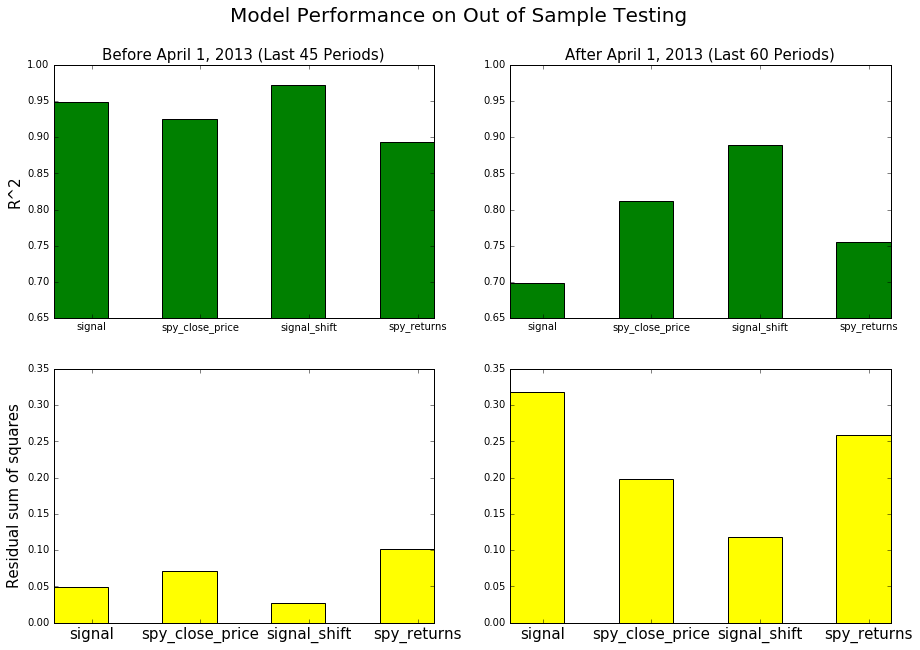

In [183]:
#now let's look at the model performances
#for first half of the data:

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
ax1=plt.bar(np.arange(4),mcb['R^2'],color='green',width=0.5)
ax1=plt.title('Before April 1, 2013 (Last 45 Periods)',fontsize=15)
ax1=plt.xticks(np.arange(4)+0.35,a)
ax1=plt.ylabel('R^2',fontsize=15)
ax1=plt.ylim(ymin=0.65,ymax=1)

ax2 = fig.add_subplot(222)
ax2=plt.bar(np.arange(4),mca['R^2'],color='green',width=0.5)
ax2=plt.title('After April 1, 2013 (Last 60 Periods)',fontsize=15)
ax2=plt.xticks(np.arange(4)+0.3,a)
ax2=plt.ylim(ymin=0.65,ymax=1)

ax3 = fig.add_subplot(223)
ax3=plt.bar(np.arange(4),mcb['Residual sum of squares'],color='yellow',width=0.5)
ax3=plt.xticks(np.arange(4)+0.35,a,fontsize=15)
ax3=plt.ylabel('Residual sum of squares',fontsize=15)
ax3=plt.ylim(ymax=0.35)

ax4 = fig.add_subplot(224)
ax4=plt.bar(np.arange(4),mca['Residual sum of squares'],color='yellow',width=0.5)
ax4=plt.xticks(np.arange(4)+0.3,a,fontsize=15)
ax4=plt.ylim(ymax=0.35)

fig.suptitle('Model Performance on Out of Sample Testing',fontsize=20)
plt.show

### SVM is the winning model according to R^2 and RSS, and the model fits the first half better than the second half. Let's now see the fit plot.

In [179]:
mcb[mcb['Model']=='SVM']

,Model,R^2,Residual sum of squares,Best Parameters,Data_Range
4,SVM,0.971915,0.026684,"{u'kernel': u'linear', u'C': 50}",1


In [180]:
mca[mca['Model']=='SVM']

,Model,R^2,Residual sum of squares,Best Parameters,Data_Range
5,SVM,0.888635,0.117518,"{u'kernel': u'linear', u'C': 10}",2


In [181]:
clf = svm.SVR(C=50,kernel='linear')
y_1_svr=clf.fit(X_1_training,y_1_training).predict(X_1_test)
x_range=df_lag2.loc['2012-01-13':'2013-03-31'].index[-45:]
clf2 = svm.SVR(C=10,kernel='linear')
y_2_svr=clf2.fit(X_2_training,y_2_training).predict(X_2_test)
x_range2=df_lag2.loc['2013-04-01':'2014-08-29'].index[-60:]

<function matplotlib.pyplot.show>

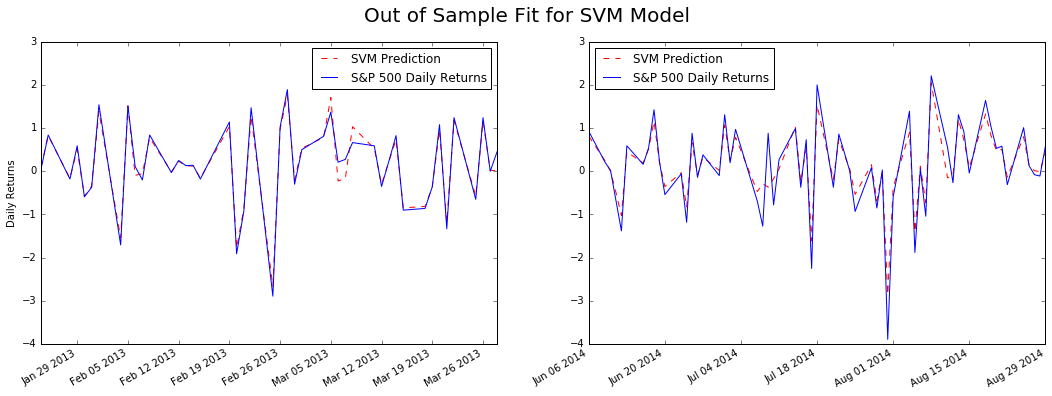

In [182]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1=plt.plot(x_range, y_1_svr, 'r--',label='SVM Prediction')
ax1=plt.plot(x_range, y_1_test, c='b', label='S&P 500 Daily Returns')
ax1=plt.legend(loc='best')
ax1=plt.ylabel('Daily Returns')
ax1=plt.ylim(ymin=-4,ymax=3)
ax2 = fig.add_subplot(122)
ax2=plt.plot(x_range2, y_2_svr, 'r--', label='SVM Prediction')
ax2=plt.plot(x_range2, y_2_test, c='b', label='S&P 500 Daily Returns')
ax2=plt.legend(loc='best')
ax2=plt.ylim(ymin=-4,ymax=3)
fig.autofmt_xdate()
fig.suptitle('Out of Sample Fit for SVM Model',fontsize=20)
plt.show

Note at the end: Our SVM model fit is achieved by using the entire time series data available before the testing period. In practice I can consider using a moving window of data to constantly refitting the model, so that when the situation changes (such as the one in April 2013), the model can adjust to the new situation. Also when such a regime change happens, we might have very little information at the beginning to refit the model (since the old data are no long relevant). A simpler model that requires less data might be preferred at the first. As we accumulate more data, a more complex model and more accurate model can be fitted. 